### Re-produces dot plot figure and Table 1

#### Load saved embeddings and preprocess

In [ ]:
# requires(c('FNN','dplyr','matrixStats', 'limma', 'msImpute'))

In [1]:
query_embedding <- read.csv('~/ion_mobility/peptideprotonet_embedding_space_90Kto20KsplitTrain_epoch300_featuresScaled_HeLa4Reps_200ng_100ms_noEvidenceTrain.csv')

refrence_data <- read.csv('~/ion_mobility/peptideprotonet_embedding_space_90Kto20KsplitTrain_epoch300_featuresScaled_EvidenceTrain.csv')

# note this is called tcell, but it is actually PXD010012_PASEFF data
tcells_evidence <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD010012_PASEFF/HeLa_200ng_100ms_txt/txt/evidence.txt")

# keep only MSMS evidence
tcells_evidence <- tcells_evidence[tcells_evidence$Type %in% "MULTI-MSMS",]
tcells_evidence$PrecursorID <- paste(tcells_evidence$Modified.sequence, tcells_evidence$Charge, sep="")
tcells_evidence$Species <- "HeLa_query"

query <- query_embedding # grep("dim|Raw.file", colnames(data))
reference <- refrence_data #  grep("dim", colnames(data))
query$Raw.file.id <- as.numeric(as.factor(query$Raw.file))
tcells_evidence$Raw.file.id <- as.numeric(as.factor(tcells_evidence$Raw.file))


lc_ms_anchors  <- c("Raw.file.id", "Charge","m.z", "Mass", "Intensity","Retention.time")


tcells_evidence <- tcells_evidence[complete.cases(tcells_evidence[, lc_ms_anchors]),]
query <- query[complete.cases(query[, lc_ms_anchors]),]

identified_peptides <- FNN::get.knnx(query[, lc_ms_anchors], tcells_evidence[, lc_ms_anchors], k=1)
identified_peptides <- query[identified_peptides$nn.index,]
identified_peptides$PrecursorID <- tcells_evidence$PrecursorID
identified_peptides$Species <- tcells_evidence$Species


unidentified_peptides <- dplyr::anti_join(query, identified_peptides,
                                            by = lc_ms_anchors)



reference_combined <- rbind(reference[,c(grep("dim", colnames(reference), value = TRUE), "Charge", "PrecursorID", "Species")],
                            identified_peptides[,c(grep("dim", colnames(reference), value = TRUE), "Charge" ,"PrecursorID", "Species")])
                            
unidentified_peptides_latent <- unidentified_peptides[, grep("dim", colnames(unidentified_peptides))]


reference_latent <- reference_combined[, grep("dim", colnames(reference_combined))]
reference_charge <- reference_combined$Charge
reference_ident_labels <- reference_combined$PrecursorID
reference_ident_species <- reference_combined$Species


all_unidentified_peptides <- unidentified_peptides

In [2]:
### this chuck implements the two-pass approach

reference_combined <- rbind(reference[,c(grep("dim", colnames(reference), value = TRUE), "Charge", "PrecursorID", "Species")],
                            identified_peptides[,c(grep("dim", colnames(reference), value = TRUE), "Charge" ,"PrecursorID", "Species")])
                            
# reference_combined <- reference_combined[grep("ox|Deamidation|Acetyl|Oxidation|ac", reference_combined$PrecursorID, invert=TRUE),]







unidentified_peptides_latent <- unidentified_peptides[, grep("dim", colnames(unidentified_peptides))]
#k = 10





reference_combined_sub <- reference_combined[reference_combined$Species %in% c("HeLa","Yeast"), ] # c("HeLa","Human","Yeast")

# reference_combined_sub <- reference_combined
reference_latent <- reference_combined_sub[, grep("dim", colnames(reference_combined_sub))]
#reference_latent <- t(apply(reference_latent, 1, FUN=function(x) x/sqrt(sum(x^2))))
reference_charge <- reference_combined_sub$Charge
reference_ident_labels <- reference_combined_sub$PrecursorID
reference_ident_species <- reference_combined_sub$Species




study_embedding <- reference_combined[reference_combined$Species %in% c("HeLa_query","Yeast"), ] # c("HeLa","Human","Yeast")
study_latent <- study_embedding[, grep("dim", colnames(study_embedding))]
#study_latent <- t(apply(study_latent, 1, FUN=function(x) x/sqrt(sum(x^2)) ))
study_charge <- study_embedding$Charge
study_ident_labels <- study_embedding$PrecursorID
study_ident_species <- study_embedding$Species






tcells_evidence_dedupped <- tcells_evidence[, c("Raw.file","PrecursorID")]
tcells_evidence_dedupped <- tcells_evidence_dedupped[!duplicated(tcells_evidence_dedupped),]
# tcells_evidence_dedupped <- tcells_evidence_dedupped[grep("ox|Deamidation|Acetyl|Oxidation|ac", tcells_evidence_dedupped$PrecursorID, invert=TRUE),]

Use `computeStats()` for label (peptide identity propagation) and computing false transfers, coverage, new identifications transferred etc 

In [3]:
computeStats <- function(thr, k){
  
  false_transfer_rate <- c()
  # coverage_per_run <- c()
  total_idents_per_run_after_transfer <- c()
  number_new_ident <- c()
  coverage_per_run_after_transfer <- c()
  coverage_per_run_before_transfer <- c()
  ident_list <- list()
  
  itr = 1
  
  for (run in unique(tcells_evidence_dedupped$Raw.file)){
    
    message(run)
    missing_idents <- setdiff(tcells_evidence_dedupped$PrecursorID,
                              tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file == run])
  
    latent_study <- study_latent[study_embedding$PrecursorID %in% missing_idents,]
    s_charge <- study_charge[study_embedding$PrecursorID %in% missing_idents]
    s_ident_labels <- study_ident_labels[study_embedding$PrecursorID %in% missing_idents]
    s_ident_species <- study_ident_species[study_embedding$PrecursorID %in% missing_idents]
  
  
    run_query_peptides <- unidentified_peptides[unidentified_peptides$Raw.file %in% run,]
  
    run_query_peptides_latent <- run_query_peptides[, grep("dim", colnames(run_query_peptides))]
    #run_query_peptides_latent <- t(apply(run_query_peptides_latent, 1, FUN=function(x) x/sqrt(sum(x^2))))
    query_feature_charges <- run_query_peptides$Charge
    run_query_peptides_intensity <- run_query_peptides$Intensity
  
  
    knn_prototypes <- FNN::get.knnx(

        latent_study,
        run_query_peptides_latent,
      k = k) 
  
    probs <- exp(-0.5*((knn_prototypes$nn.dist^2)/matrixStats::rowSds(knn_prototypes$nn.dist^2)))
    # probs <- 1 - knn_prototypes$nn.dist^2
    ww <- matrix(s_charge[knn_prototypes$nn.index], nrow = nrow(probs), ncol = ncol(probs))
    charge <- matrix(query_feature_charges, nrow = nrow(ww), ncol = ncol(ww), byrow = FALSE)
    w <- ifelse(ww==charge, 1, 0)
  
  
  
  
  
    transferred_idents <- matrix(s_ident_labels[knn_prototypes$nn.index], 
                               nrow = nrow(probs), ncol = ncol(probs))
    transferred_species <- matrix(s_ident_species[knn_prototypes$nn.index], 
                                nrow = nrow(probs), ncol = ncol(probs))


    # probs <- w*probs
    # probs <- probs/rowSums(probs)
    # probs[!is.finite(probs)] <- 0

    transferred_idents[w==0] <- "other"
    transferred_species[w==0] <- "other"


    unmapped_queries <- (rowSums(probs < thr) == k)
    
    false_transfers_co <- which(rowSums(probs >= thr & transferred_species == c("Yeast") ) > 1)
    length(false_transfers_co)
  
  
    correct_transfers <-  (rowSums(probs >= thr & (transferred_species == "HeLa_query" | transferred_species == "HeLa") )> 2)
    correct_transfers_run_names <- run_query_peptides$Raw.file[correct_transfers]
    correct_transfer_idents <- transferred_idents[correct_transfers,]
    correct_transfer_idents <- apply(correct_transfer_idents,1, FUN=function(x) {
      z <- table(x)
      z <- z[!grepl("other", names(z))]
      names(z)[which.max(z)]}
      )
  
    correct_transfer_idents <- gsub("__","_",correct_transfer_idents)
    transfer_idents <- do.call(cbind, list(correct_transfers_run_names, correct_transfer_idents,
                                           run_query_peptides_intensity[correct_transfers]))
    transfer_idents <- data.frame(transfer_idents)
    colnames(transfer_idents) <- c("Raw.file","PrecursorID","Intensity")
    transfer_idents$PrecursorID <- gsub("__","_", transfer_idents$PrecursorID)
  
    
    
    ### computation of false transfers-------
    
    # false_transfer_rate[itr] <- length(false_transfers)
    
    query_feature_charges <- run_query_peptides$Charge[unmapped_queries]
    unmapped_queries_latent <- run_query_peptides_latent[unmapped_queries,]
    unmapped_queries_inetnsity <- run_query_peptides_intensity[unmapped_queries]
    
    if(nrow(unmapped_queries_latent) > 0 ) {
      
      
      ex_prototypes <- FNN::get.knnx(

        reference_latent,
        unmapped_queries_latent,
      k = k) 
  
    ex_probs <- exp(-0.5*((ex_prototypes$nn.dist^2)/matrixStats::rowSds(ex_prototypes$nn.dist^2)))
    # ex_probs <- 1 - ex_prototypes$nn.dist^2
    ww2 <- matrix(reference_charge[ex_prototypes$nn.index], nrow = nrow(ex_probs), ncol = ncol(ex_probs))
    charge_ex <- matrix(query_feature_charges, nrow = nrow(ww2), ncol = ncol(ww2), byrow = FALSE)
    w2 <- ifelse(ww2==charge_ex, 1, 0)
  
  
  
  
  
    transferred_idents <- matrix(reference_ident_labels[ex_prototypes$nn.index], 
                               nrow = nrow(ex_probs), ncol = ncol(ex_probs))
    transferred_species <- matrix(reference_ident_species[ex_prototypes$nn.index], 
                                nrow = nrow(ex_probs), ncol = ncol(ex_probs))


    #ex_probs <- w2*ex_probs
    #ex_probs <- ex_probs/rowSums(ex_probs)
    # ex_probs[!is.finite(ex_probs)] <- 0

    transferred_idents[w2==0] <- "other"
    transferred_species[w2==0] <- "other"
    
    
    false_transfers <- which(rowSums(ex_probs >= thr & transferred_species == c("Yeast")) > 1)
    length(false_transfers)
    
    
    
    new_transfers <- which(rowSums(ex_probs >= thr & (transferred_species == "HeLa") ) > 1)
    #table(new_transfers)
    
    if(length(new_transfers) > 0){
      
      new_transfers_run_names <- run_query_peptides$Raw.file[unmapped_queries][new_transfers]
      new_transfer_idents <- transferred_idents[new_transfers,, drop=FALSE]
      new_transfer_idents <- apply(new_transfer_idents,1, FUN=function(x) {
        z <- table(x)
        z <- z[!grepl("other", names(z))]
        names(z)[which.max(z)]
        }
      )
  
      new_transfer_idents <- gsub("__","_", new_transfer_idents)
      transfer_idents2 <- do.call(cbind, list(new_transfers_run_names, new_transfer_idents,
                                              unmapped_queries_inetnsity[new_transfers]))
      transfer_idents2 <- data.frame(transfer_idents2)
      colnames(transfer_idents2) <- c("Raw.file","PrecursorID","Intensity")
      transfer_idents2$PrecursorID <- gsub("__","_", transfer_idents2$PrecursorID)
  
      total_transferred_idents <- rbind(transfer_idents2, transfer_idents)
      number_new_ident[itr] <- length(setdiff(transfer_idents2$PrecursorID, tcells_evidence_dedupped$PrecursorID))
    } else {
      total_transferred_idents <- transfer_idents
      number_new_ident[itr] <- 0
    }
    
     
    false_transfers <- c(false_transfers, false_transfers_co)
    false_transfer_rate[itr] <- length(false_transfers)/length(union(total_transferred_idents$PrecursorID,
                                                                      tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run]))
     
    } else{
      
      
      
      total_transferred_idents <- transfer_idents
      false_transfer_rate[itr] <- length(false_transfers_co)/length(union(total_transferred_idents$PrecursorID,
                                                                      tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run]))
      number_new_ident[itr] <- 0
      
    }
    
     
    
    
    
    # need to store raw file, precursor and Intensity
    all_idents <- rbind(cbind(tcells_evidence[tcells_evidence$Raw.file %in% run, 
                                        c("Raw.file","PrecursorID","Intensity")],
                              type = "TIMS-MULTI-MSMS"),
                        cbind(total_transferred_idents, type = "PIP")
    )
    
    all_idents_in_run <- union(total_transferred_idents$PrecursorID,
                               tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run])
    
    coverage_per_run_after_transfer[itr] <- length(intersect(all_idents_in_run, tcells_evidence_dedupped$PrecursorID))/ length(unique(tcells_evidence_dedupped$PrecursorID))
    
    
    coverage_per_run_before_transfer[itr] <- length(intersect(tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run], tcells_evidence_dedupped$PrecursorID))/ length(unique(tcells_evidence_dedupped$PrecursorID))
    
    

    total_idents_per_run_after_transfer[itr] <- length(all_idents_in_run)
    ident_list[[itr]] <- data.frame(all_idents)

   
    
    itr = itr + 1
     
    
  
  }
  
  ALL_IDENTS <- do.call(rbind, ident_list)
  return(list("threshold" = rep(thr, length(unique(tcells_evidence_dedupped$Raw.file))), 
              "false_transfer_rate" = false_transfer_rate, 
                         #"median_coverage" = med_cov_per_run, 
              "coverage_before_transfer" = coverage_per_run_before_transfer,
              "coverage_after_transfer" = coverage_per_run_after_transfer,
              "number_new_idents" = number_new_ident,
              "total_idents_per_run_after_PIP" = total_idents_per_run_after_transfer,
              "identifications" = ALL_IDENTS))
}

Quantify PIPP for $k=10,5, 3$ and various cutoffs:

In [4]:
############# Tabularise results for different cut-offs

results_k10 <- list()
itr = 1
for (thr in c(0, 0.01, 0.05, 0.2,0.5, 0.8)){
  res <- computeStats(thr, k = 10)
  results_k10[[itr]] <- list("threshold" = thr, "false_transfer_rate" = median(res$false_transfer_rate), 
                         "mean_coverage" = median(res$coverage_before_transfer), 
                         "mean_coverage_after_transfer" = mean(res$coverage_after_transfer),
                         "max_coverage_after_transfer" = max(res$coverage_after_transfer),
                         "N_new_idents" = round(median(res$number_new_idents)),
                         "median_idents_per_run_after_PIP" = round(median(res$total_idents_per_run_after_PIP)),
                         "identifications" = res$identifications)
  
  itr = itr + 1
  
}

coverage_results <- lapply(results_k10, FUN=function(x)  x[!grepl("identifications", names(x))])

(dt_k10 <- data.frame(do.call(rbind, coverage_results)))
dt_k10 <- data.frame(round(data.matrix(dt_k10),3))





results_5k <- list()
itr = 1
for (thr in c(0, 0.01, 0.05, 0.2,0.5, 0.8)){
  res <- computeStats(thr, k = 5)
  results_5k[[itr]] <- list("threshold" = thr, "false_transfer_rate" = median(res$false_transfer_rate), 
                         "mean_coverage" = median(res$coverage_before_transfer), 
                         "mean_coverage_after_transfer" = mean(res$coverage_after_transfer),
                         "max_coverage_after_transfer" = max(res$coverage_after_transfer),
                         "N_new_idents" = round(median(res$number_new_idents)),
                         "median_idents_per_run_after_PIP" = round(median(res$total_idents_per_run_after_PIP)),
                         "identifications" = res$identifications)
  
  itr = itr + 1
  
}

coverage_results <- lapply(results_5k, FUN=function(x)  x[!grepl("identifications", names(x))])

(dt_k5 <- data.frame(do.call(rbind, coverage_results)))
dt_k5 <- data.frame(round(data.matrix(dt_k5),3))





results_3k <- list()
itr = 1
for (thr in c(0, 0.01, 0.05, 0.2,0.5, 0.8)){
  res <- computeStats(thr, k = 3)
  results_3k[[itr]] <- list("threshold" = thr, "false_transfer_rate" = median(res$false_transfer_rate), 
                         "mean_coverage" = median(res$coverage_before_transfer), 
                         "mean_coverage_after_transfer" = mean(res$coverage_after_transfer),
                         "max_coverage_after_transfer" = max(res$coverage_after_transfer),
                         "N_new_idents" = round(median(res$number_new_idents)),
                         "median_idents_per_run_after_PIP" = round(median(res$total_idents_per_run_after_PIP)),
                         "identifications" = res$identifications)
  
  itr = itr + 1
  
}

coverage_results <- lapply(results_3k, FUN=function(x)  x[!grepl("identifications", names(x))])

(dt_k3 <- data.frame(do.call(rbind, coverage_results)))
dt_k3 <- data.frame(round(data.matrix(dt_k3),3))


20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIM

threshold,false_transfer_rate,mean_coverage,mean_coverage_after_transfer,max_coverage_after_transfer,N_new_idents,median_idents_per_run_after_PIP
<list>,<list>,<list>,<list>,<list>,<list>,<list>
0,0,0.7071961,0.8523245,0.8551129,0,47698
0.01,0.003890677,0.7071961,0.8518821,0.8544873,189,47860
0.05,0.007076717,0.7071961,0.8510778,0.8537366,376,47978
0.2,0.007798644,0.7071961,0.8424714,0.8453536,580,47686
0.5,0.003398384,0.7071961,0.7946449,0.7994173,374,44877
0.8,0.0001976244,0.7071961,0.7207938,0.7269022,35,40440


20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIM

threshold,false_transfer_rate,mean_coverage,mean_coverage_after_transfer,max_coverage_after_transfer,N_new_idents,median_idents_per_run_after_PIP
<list>,<list>,<list>,<list>,<list>,<list>,<list>
0,0,0.7071961,0.9019161,0.9042665,0,50445
0.01,0.01132485,0.7071961,0.9011967,0.9037482,824,51224
0.05,0.01201339,0.7071961,0.8977291,0.9004772,1010,51234
0.2,0.00804164,0.7071961,0.8775895,0.8802259,886,49990
0.5,0.0021841,0.7071961,0.765689,0.7709082,358,43254
0.8,8.812622e-05,0.7071961,0.7113116,0.718001,18,39901


20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_2_A1_01_2768

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_3_A1_01_2769

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_4_A1_01_2770

20180819_TIMS2_12-2_AnBr_SA_200ng_HeLa_50cm_120min_100ms_11CT_1_A1_01_2767

20180819_TIM

threshold,false_transfer_rate,mean_coverage,mean_coverage_after_transfer,max_coverage_after_transfer,N_new_idents,median_idents_per_run_after_PIP
<list>,<list>,<list>,<list>,<list>,<list>,<list>
0,0,0.7071961,0.9389869,0.9407475,0,52526
0.01,0.0140598,0.7071961,0.9344826,0.9360645,1354,53658
0.05,0.01140709,0.7071961,0.9268325,0.9288076,1248,53125
0.2,0.005722979,0.7071961,0.8877911,0.8906465,830,50500
0.5,0.001520105,0.7071961,0.7071246,0.7139614,256,39906
0.8,6.299991e-05,0.7071961,0.7056947,0.7125315,12,39582


In [5]:
# Coefficient of variation for MQ+/- MBR
devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")


data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD010012_PASEFF/HeLa_200ng_100ms_txt/txt/evidence.txt", 
                   stringsAsFactors = FALSE)


table(data$Type)

# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


genes <- data[,c("PeptideID","matrix.row.id", "Leading.razor.protein")]
genes <- genes[!duplicated(genes),]


y_noMBR <- evidenceToMatrix(data)
genes <- genes[match(rownames(y_noMBR), genes$PeptideID),]



mean(complete.cases(y_noMBR))

dim(y_noMBR)  



mean(colSums(!is.na(y_noMBR))/nrow(y_noMBR))


median(matrixStats::rowSds(y_noMBR, na.rm = TRUE)/rowMeans(y_noMBR, na.rm = TRUE), na.rm = TRUE)



median(matrixStats::rowSds(y_noMBR[complete.cases(y_noMBR),])/rowMeans(y_noMBR[complete.cases(y_noMBR),]))


ynombr <- limma::normalizeBetweenArrays(log2(y_noMBR), method = "quantile")

# this
median(matrixStats::rowSds(ynombr, na.rm = TRUE)/rowMeans(ynombr, na.rm = TRUE), na.rm = TRUE)

# vs this
median(matrixStats::rowSds(ynombr[complete.cases(ynombr),])/rowMeans(ynombr[complete.cases(ynombr),]))



sumTopN <- function(x, n=3 , na.rm = TRUE){
  sum(sort(x, decreasing = TRUE)[1:n], na.rm=na.rm)
}

ygene_mq <- aggregate(.~ ProteinID,  FUN=sumTopN, 
                      data = data.frame(ynombr, ProteinID = genes$Leading.razor.protein),
                   na.action = na.pass
                   #na.rm=TRUE, trim = 0.2
                   )
rownames(ygene_mq) <- ygene_mq$ProteinID
ygene_mq$ProteinID <- NULL
ygene_mq[ygene_mq==0] <- NA
ygene_mq[!is.finite(data.matrix(ygene_mq))] <- NA

ygene_mq <- data.matrix(ygene_mq)
#ygene_mq <- limma::normalizeBetweenArrays(log2(ygene_mq), method = "quantile")

median(matrixStats::rowSds(ygene_mq, na.rm = TRUE)/rowMeans(ygene_mq, na.rm = TRUE), na.rm = TRUE)

ℹ Loading msImpute




MULTI-MSMS 
    166766 

Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”

[1] 0.4369395

[1] 53639     4

[1] 0.7120053

[1] 0.130867

[1] 0.1186644

[1] 0.01197585

[1] 0.01053783

[1] 0.02073845

In [6]:
## Coefficient of variation for PIP at each threshold
cv_results_k10 <- list()
for (j in seq_along(results_k10)){
  z <- results_k10[[j]]$identifications
  z$Intensity <- as.numeric(z$Intensity)
  m <- evidenceToMatrix(z, peptide_id = "PrecursorID")
  print(table(!grepl("^_", rownames(m))))
  
  m <- m[grepl("^_", rownames(m)), ]
  # m <- m[!grepl("_\\(.*\\)", rownames(m)),]
  # print(tail(m))
   m <- m[match(rownames(y_noMBR), rownames(m)),]
   m <- limma::normalizeBetweenArrays(log2(m), method = "quantile")
  
  pIds <- genes$Leading.razor.protein
  ygene <- aggregate(.~ ProteinID, FUN=sumTopN, data = data.frame(m, ProteinID = pIds),
                   na.action = na.pass
                   #na.rm=TRUE, trim = 0.2
                   )
  rownames(ygene) <- ygene$ProteinID
  ygene$ProteinID <- NULL
  ygene[ygene==0] <- NA
  ygene[!is.finite(data.matrix(ygene))] <- NA
  ygene <- data.matrix(ygene)
  
  cv_peptide <- median(matrixStats::rowSds(m, na.rm = TRUE)/rowMeans(m, na.rm = TRUE), na.rm = TRUE)
  # cv_peptide <- median(matrixStats::rowSds(m[complete.cases(m),], na.rm = TRUE)/rowMeans(m[complete.cases(m),]))
  cv_protein <- median(matrixStats::rowSds(ygene, na.rm = TRUE)/rowMeans(ygene, na.rm = TRUE), na.rm = TRUE)
  cv_results_k10[[j]] <- list("threshold" = results_k10[[j]]$thr[1],
                          "CV_peptide" = cv_peptide,
                          "CV_protein" = cv_protein,
                          "total_idents" = nrow(m),
                          "complete_cases" = mean(complete.cases(m)))
}




cv_results_k10[[length(cv_results_k10) +1]] <- list("threshold" = "MQ-MBR", 
                                  # "CV_peptide" = median(matrixStats::rowSds(ynombr[complete.cases(ynombr),], na.rm = TRUE)/rowMeans(ynombr[complete.cases(ynombr),])),
                                  "CV_peptide" = median(matrixStats::rowSds(ynombr, na.rm = TRUE)/rowMeans(ynombr, na.rm = TRUE), na.rm = TRUE),
                                  "CV_protein" = median(matrixStats::rowSds(ygene_mq, na.rm = TRUE)/rowMeans(ygene_mq, na.rm = TRUE), na.rm = TRUE),
                                  "total_idents" = nrow(y_noMBR),
                                  "complete_cases" = mean(complete.cases(y_noMBR)))

(cv_results_k10 <- do.call(rbind, cv_results_k10))
cv_results_k10 <- data.frame(cv_results_k10)
cv_results_k10 <- data.frame(round(data.matrix(cv_results_k10), 3))
cv_results_k10[is.na(cv_results_k10)] <- "MaxQuant-MBR"



cv_results_k5 <- list()
for (j in seq_along(results_5k)){
  z <- results_5k[[j]]$identifications
  z$Intensity <- as.numeric(z$Intensity)
  m <- evidenceToMatrix(z, peptide_id = "PrecursorID")
  print(table(!grepl("^_", rownames(m))))
  
  m <- m[grepl("^_", rownames(m)), ]
  # m <- m[!grepl("_\\(.*\\)", rownames(m)),]
  # print(tail(m))
  
  m <- m[match(rownames(y_noMBR), rownames(m)),]
  
  m <- limma::normalizeBetweenArrays(log2(m), method = "quantile")
  
  pIds <- genes$Leading.razor.protein
  ygene <- aggregate(.~ ProteinID, FUN=sumTopN, data = data.frame(m, ProteinID = pIds),
                   na.action = na.pass
                   #na.rm=TRUE, trim = 0.2
                   )
  rownames(ygene) <- ygene$ProteinID
  ygene$ProteinID <- NULL
  ygene[ygene==0] <- NA
  # m <- m[rowSums(is.na(m)) != 4, ]
  ygene[!is.finite(data.matrix(ygene))] <- NA
  ygene <- data.matrix(ygene)
  
  cv_peptide <- median(matrixStats::rowSds(m, na.rm = TRUE)/rowMeans(m, na.rm = TRUE), na.rm = TRUE)
  # cv_peptide <- median(matrixStats::rowSds(m[complete.cases(m),], na.rm = TRUE)/rowMeans(m[complete.cases(m),]))
  cv_protein <- median(matrixStats::rowSds(ygene, na.rm = TRUE)/rowMeans(ygene, na.rm = TRUE), na.rm = TRUE)
  cv_results_k5[[j]] <- list("threshold" = results_5k[[j]]$thr[1],
                          "CV_peptide" = cv_peptide,
                          "CV_protein" = cv_protein,
                          "total_idents" = nrow(m),
                          "complete_cases" = mean(complete.cases(m)))
}

cv_results_k5[[length(cv_results_k5) +1]] <- list("threshold" = "MQ-MBR", 
                                  # "CV_peptide" = median(matrixStats::rowSds(ynombr[complete.cases(ynombr),], na.rm = TRUE)/rowMeans(ynombr[complete.cases(ynombr),])),
                                   "CV_peptide" = median(matrixStats::rowSds(ynombr, na.rm = TRUE)/rowMeans(ynombr, na.rm = TRUE), na.rm = TRUE),
                                  "CV_protein" = median(matrixStats::rowSds(ygene_mq, na.rm = TRUE)/rowMeans(ygene_mq, na.rm = TRUE), na.rm = TRUE),
                                  "total_idents" = nrow(y_noMBR),
                                  "complete_cases" = mean(complete.cases(y_noMBR)))

(cv_results_k5 <- do.call(rbind, cv_results_k5))
cv_results_k5 <- data.frame(cv_results_k5)
cv_results_k5 <- data.frame(round(data.matrix(cv_results_k5), 3))
cv_results_k5[is.na(cv_results_k5)] <- "MaxQuant-MBR"





cv_results_k3 <- list()
for (j in seq_along(results_3k)){
  z <- results_3k[[j]]$identifications
  z$Intensity <- as.numeric(z$Intensity)
  m <- evidenceToMatrix(z, peptide_id = "PrecursorID")
  print(table(!grepl("^_", rownames(m))))
  
  m <- m[grepl("^_", rownames(m)), ]
  # m <- m[!grepl("_\\(.*\\)", rownames(m)),]
  # print(tail(m))
  
  m <- m[match(rownames(y_noMBR), rownames(m)),]
  # m <- m[rowSums(is.na(m)) != 4, ]
  m <- limma::normalizeBetweenArrays(log2(m), method = "quantile")
  
  pIds <- genes$Leading.razor.protein
  ygene <- aggregate(.~ ProteinID, FUN=sumTopN, data = data.frame(m, ProteinID = pIds),
                   na.action = na.pass 
                   #na.rm=TRUE, trim = 0.2
                   )
  rownames(ygene) <- ygene$ProteinID
  ygene$ProteinID <- NULL
  ygene[ygene==0] <- NA
  ygene[!is.finite(data.matrix(ygene))] <- NA
  ygene <- data.matrix(ygene)
  
  cv <- median(matrixStats::rowSds(m, na.rm = TRUE)/rowMeans(m, na.rm = TRUE), na.rm = TRUE)
  # cv <- median(matrixStats::rowSds(m[complete.cases(m),], na.rm = TRUE)/rowMeans(m[complete.cases(m),]))
  cv_protein <- median(matrixStats::rowSds(ygene, na.rm = TRUE)/rowMeans(ygene, na.rm = TRUE), na.rm = TRUE)
  cv_results_k3[[j]] <- list("threshold" = results_3k[[j]]$thr[1],
                          "CV_peptide" = cv,
                          "CV_protein" =  cv_protein,
                          "total_idents" = nrow(m),
                          "complete_cases" = mean(complete.cases(m)))
}

cv_results_k3[[length(cv_results_k3) +1]] <- list("threshold" = "MQ-MBR", 
                                  # "CV_peptide" = median(matrixStats::rowSds(ynombr[complete.cases(ynombr),], na.rm = TRUE)/rowMeans(ynombr[complete.cases(ynombr),])),
                                  "CV_peptide" = median(matrixStats::rowSds(ynombr, na.rm = TRUE)/rowMeans(ynombr, na.rm = TRUE), na.rm = TRUE),
                                  "CV_protein" = median(matrixStats::rowSds(ygene_mq, na.rm = TRUE)/rowMeans(ygene_mq, na.rm = TRUE), na.rm = TRUE),
                                  "total_idents" = nrow(y_noMBR),
                                  "complete_cases" = mean(complete.cases(y_noMBR)))

(cv_results_k3 <- do.call(rbind, cv_results_k3))
cv_results_k3 <- data.frame(cv_results_k3)
cv_results_k3 <- data.frame(round(data.matrix(cv_results_k3), 3))
cv_results_k3[is.na(cv_results_k3)] <- "MaxQuant MBR-"



FALSE 
55947 

FALSE 
56542 

FALSE 
57048 

FALSE 
57540 

FALSE 
57055 

FALSE 
56065 


threshold CV_peptide CV_protein total_idents complete_cases
[1,] 0         0.03399554 0.03102196 53639        0.770074      
[2,] 0.01      0.03387381 0.03086246 53639        0.7695147     
[3,] 0.05      0.03362089 0.03019141 53639        0.7678741     
[4,] 0.2       0.03081319 0.02699605 53639        0.7501258     
[5,] 0.5       0.02124808 0.02088799 53639        0.6462835     
[6,] 0.8       0.0127351  0.02026817 53639        0.4764444     
[7,] MQ-MBR    0.01197585 0.02073845 53639        0.4369395

Warning message in data.matrix(cv_results_k10):
“NAs introduced by coercion”



FALSE 
55947 

FALSE 
58327 

FALSE 
58758 

FALSE 
58340 

FALSE 
57010 

FALSE 
56014 


threshold CV_peptide CV_protein total_idents complete_cases
[1,] 0         0.03489935 0.02920405 53639        0.8338336     
[2,] 0.01      0.03452474 0.02851181 53639        0.831093      
[3,] 0.05      0.03344864 0.02722043 53639        0.8245679     
[4,] 0.2       0.02871254 0.02291247 53639        0.785175      
[5,] 0.5       0.01631456 0.01965566 53639        0.5533474     
[6,] 0.8       0.01219249 0.020455   53639        0.4525811     
[7,] MQ-MBR    0.01197585 0.02073845 53639        0.4369395

Warning message in data.matrix(cv_results_k5):
“NAs introduced by coercion”



FALSE 
55947 

FALSE 
59305 

FALSE 
59023 

FALSE 
58064 

FALSE 
56694 

FALSE 
55992 


threshold CV_peptide CV_protein total_idents complete_cases
[1,] 0         0.03527439 0.02737491 53639        0.8811313     
[2,] 0.01      0.03350043 0.02563716 53639        0.8701318     
[3,] 0.05      0.03157512 0.02397009 53639        0.8533903     
[4,] 0.2       0.02638452 0.02026451 53639        0.7661217     
[5,] 0.5       0.01213327 0.02074765 53639        0.4388971     
[6,] 0.8       0.0119807  0.02073293 53639        0.4370514     
[7,] MQ-MBR    0.01197585 0.02073845 53639        0.4369395

Warning message in data.matrix(cv_results_k3):
“NAs introduced by coercion”


In [8]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

[1] "factor"

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



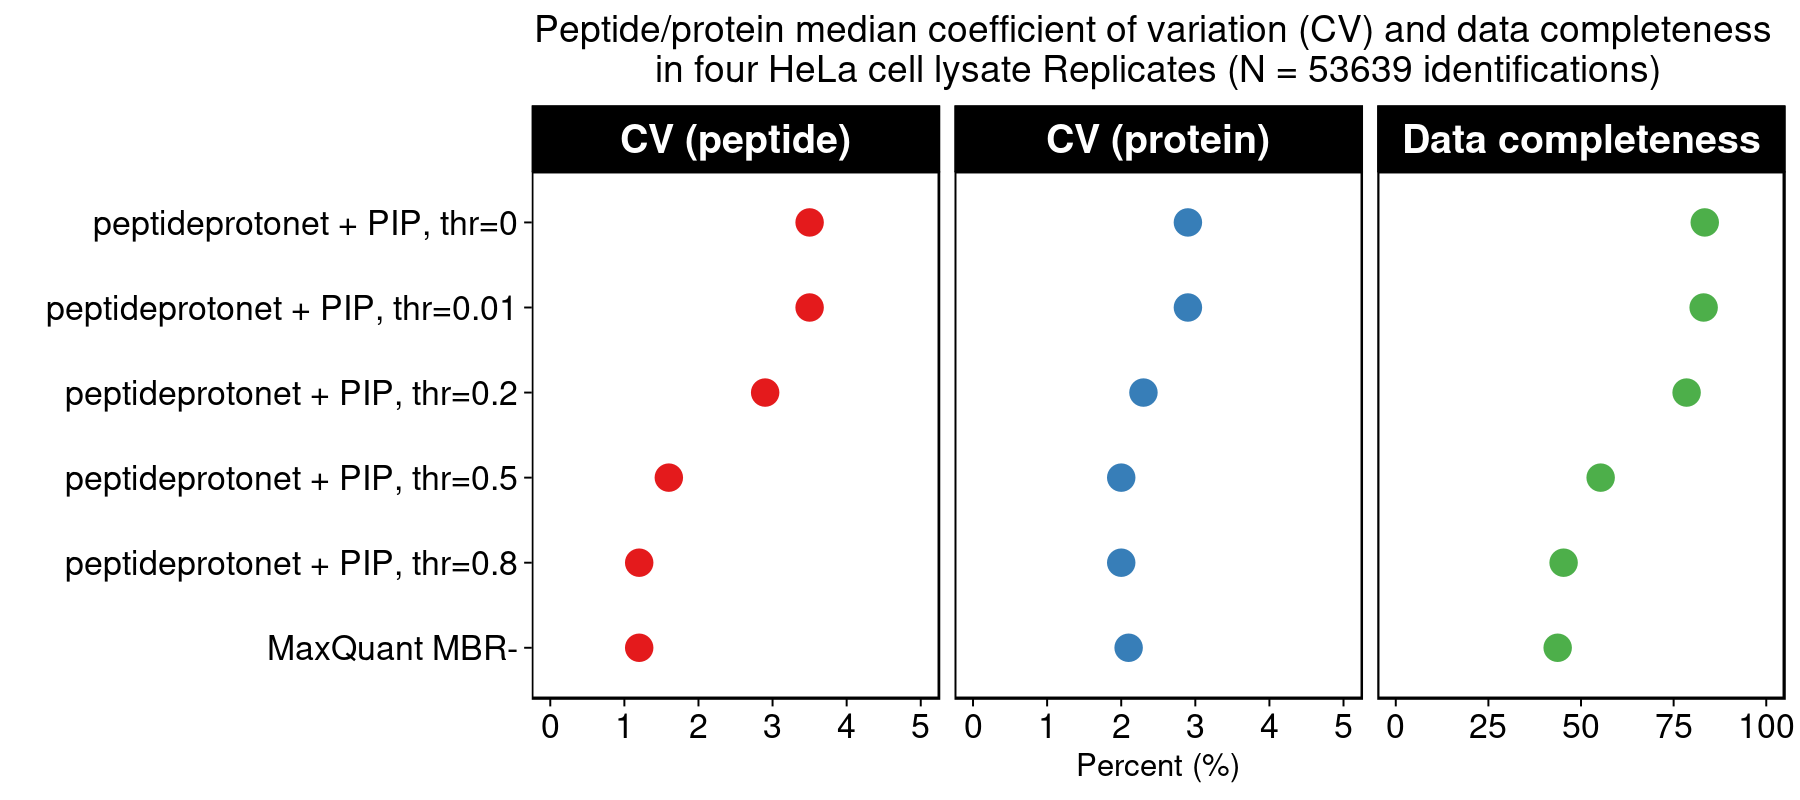

In [11]:
library(ggplot2)
library(ggsci)

fig.size(4, 9)

ggdat <- cv_results_k5
ggdat[7,1] <- gsub("MaxQuant-MBR", "MaxQuant MBR-", ggdat[7,1])
ggdat <- ggdat[ggdat$threshold %in% c(0, 0.01, 0.2, 0.5, 0.8, "MaxQuant MBR-"),]


ggdat$threshold[!grepl("Max", ggdat$threshold)] <- paste("peptideprotonet + PIP, thr=", 
                                                         ggdat$threshold[!grepl("Max", ggdat$threshold)],
                                                         sep="")

ggdat$threshold <- factor(ggdat$threshold, levels = c("MaxQuant MBR-",
                                                      "peptideprotonet + PIP, thr=0.8",
                                                      "peptideprotonet + PIP, thr=0.5",
                                                      "peptideprotonet + PIP, thr=0.2",
                                                      "peptideprotonet + PIP, thr=0.01",
                                                      "peptideprotonet + PIP, thr=0"
                                                      ))


ggdat <- reshape2::melt(ggdat, id = c("threshold", "total_idents"))
ggdat$variable <- as.factor(ggdat$variable)


# ggplot(ggdat, aes(x = threshold, y = value*100, fill = variable)) +
#   geom_bar(position = "dodge", stat = "identity") +
#   scale_y_continuous(
#     
#     # Features of the first axis
#     name = "CV (percent)",
#     
#     # Add a second axis and specify its features
#     sec.axis = sec_axis( trans=~.*1, name="Completemess (percent)")
# ) + theme_bw() + scale_fill_npg() +
#   xlab("Confidence threshold") + 
#   theme(
#     #legend.position = "None",
#         axis.text=element_text(colour="black", size = 12))

class(ggdat$threshold)

variable_names <- c("CV (peptide)", "CV (protein)", "Data completeness")
names(variable_names) <- c("CV_peptide","CV_protein", "complete_cases")


# to change the axis limits, setting it from 0 to 5% for CV or 100% for completeness
ggdat_blank <- data.frame(threshold = ggdat$threshold, variable = ggdat$variable)
ggdat_blank$value[grepl("CV", ggdat_blank$variable)] <- 0.05
ggdat_blank$value[grep("CV", ggdat_blank$variable, invert = TRUE)] <- 1

ggdat_blank[3,3] <- 0
ggdat_blank[16,3] <- 0
ggdat_blank[10,3] <- 0


ggplot(ggdat, aes(x = threshold, y = value*100, fill = variable, color = variable)) +
#   geom_bar(position = "dodge", stat = "identity") +
#   scale_y_continuous(
#     
#     # Features of the first axis
#     name = "CV (percent)",
#     
#     # Add a second axis and specify its features
#     sec.axis = sec_axis( trans=~.*1, name="Completemess (percent)")
# ) +
  
  geom_dotplot(binaxis='y', stackdir='center',
                dotsize=2) +
  coord_flip()+
  facet_wrap(.~variable, scale = "free_x",
              labeller = labeller(variable = variable_names)) +
  
  theme_linedraw() + 
  scale_fill_brewer(palette = "Set1") +
  scale_color_brewer(palette = "Set1") +
  geom_blank(data = ggdat_blank) + 
  #xlab("Confidence threshold") + 
  xlab("") +
  ylab("Percent (%)") +
  ggtitle("Peptide/protein median coefficient of variation (CV) and data completeness \nin four HeLa cell lysate Replicates (N = 53639 identifications)") +
  theme(
    plot.title = element_text(hjust = 0.5),
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    strip.text.x = element_text(
        size = 14,
        face = "bold"
        ),
    legend.position = "None",
        axis.text=element_text(colour="black", size = 12)) 


### Table 1

In [12]:
library(kableExtra)

load("~/tcells_exosome_peptideprotonet_evals.RData")
load("~/HeLa_10rep_2hr_peptideprotonet_evals_normalisedIntensity.RData")


dt <- rbind(cbind(dt_k5[, grep("max|mean_coverage$", colnames(dt_k5), invert = TRUE)], 
                  dt_k5_tcells[, grep("threshold|max|mean_coverage$", colnames(dt_k5_tcells), invert = TRUE)]),
            cbind(dt_k10[, grep("max|mean_coverage$", colnames(dt_k10), invert = TRUE)], 
                  dt_k10_tcells[, grep("threshold|max|mean_coverage$", colnames(dt_k10_tcells), invert = TRUE)])
)


dt[,2] <- dt[,2] * 100
dt[,2] <- paste0(dt[,2], "%")



dt[,6] <- dt[,6] * 100
dt[,6] <- paste0(dt[,6], "%")

dt[,8] <- as.character(dt[,8])
dt[,4] <- as.character(dt[,4])

dt <- apply(dt, 2, as.character)


In [14]:
kbl(dt, 
    format = "latex",
    booktabs = T,
    #longtable = T,
    caption = "False transfer rate and peptide coverage per run",
    col.names = c("Threshold",
                  "False transfer rate", #"False transfer rate", 
                  "Mean Coverage", #"Mean coverage after PIP",
                  "New identifications",  #"Number new identifications", 
                  "Median identifications", #"Median identifications per run",
                  "False transfer rate",
                  "Mean coverage",
                    "New identifications",
                  "Median identifications"
                  )
    # row.names = paste("threshold", dt$threshold)
    ) %>%
add_header_above(c(" ", "HeLa cell lysate replicates 2hr gradient (n = 10)[note]" = 4, "T cells OSCC (n = 6)[note]" = 4)) %>%
  pack_rows("k = 5", 1, 6) %>%
pack_rows("k = 10", 7, 12) %>%
  kable_styling(latex_options = c("scale_down"), full_width = T, position = "center") %>%
  column_spec(c(2,6), width = "4em") %>%
  column_spec(c(3:5, 7:9), width = "4em") %>%
  footnote(general = "The figures are based on peptide identifications per run.") %>%
  add_footnote(
    # general = "The figures are based on peptide identifications per run. Total identifications is the median of new and transferred peptide identifications per run.",
# number = c("Footnote 1; ", "Footnote 2; "),
# alphabet = c("Footnote A; ", "Footnote B; "),
# symbol = c("Mean peptide coverage reported by MaxQuant is 0.67 before PIP; ", 
#            "Mean peptide coverage reported by MaxQuant is 0.54 before PIP")
    
 c("Mean peptide coverage reported by MaxQuant is 0.67 before PIP; ",
           "Mean peptide coverage reported by MaxQuant is 0.54 before PIP"),
    
    notation = "symbol"
 ) 

# save_kable("peptideprotonet_PIP_false_transfer_evals.png")
# save_kable("my_latex_table.png")

\begin{table}

\caption{\label{tab:}False transfer rate and peptide coverage per run}
\centering
\resizebox{\linewidth}{!}{
\begin{tabu} to \linewidth {>{\raggedright}X>{\raggedright\arraybackslash}p{4em}>{\raggedright\arraybackslash}p{4em}>{\raggedright\arraybackslash}p{4em}>{\raggedright\arraybackslash}p{4em}>{\raggedright\arraybackslash}p{4em}>{\raggedright\arraybackslash}p{4em}>{\raggedright\arraybackslash}p{4em}>{\raggedright\arraybackslash}p{4em}}
\toprule
\multicolumn{1}{c}{ } & \multicolumn{4}{c}{HeLa cell lysate replicates 2hr gradient (n = 10)\textsuperscript{*}} & \multicolumn{4}{c}{T cells OSCC (n = 6)\textsuperscript{\dag}} \\
\cmidrule(l{3pt}r{3pt}){2-5} \cmidrule(l{3pt}r{3pt}){6-9}
Threshold & False transfer rate & Mean Coverage & New identifications & Median identifications & False transfer rate & Mean coverage & New identifications & Median identifications\\
\midrule
\addlinespace[0.3em]
\multicolumn{9}{l}{\textbf{k = 5}}\\
\hspace{1em}0.00 & 0\% & 0.909 & 0 & 57634 & 

In [15]:
# show the dataframe only
dt

threshold,false_transfer_rate,mean_coverage_after_transfer,N_new_idents,median_idents_per_run_after_PIP,false_transfer_rate,mean_coverage_after_transfer,N_new_idents,median_idents_per_run_after_PIP
0.00,0%,0.909,0,57634,0%,0.807,0,24978
0.01,1.6%,0.908,1982,59544,0.8%,0.799,928,25696
0.05,1.6%,0.902,2146,59416,1%,0.786,1218,25582
0.20,0.9%,0.875,1524,57128,0.6%,0.735,1049,23828
0.50,0.2%,0.739,484,47661,0.2%,0.593,318,18681
0.80,0%,0.679,26,43364,0%,0.547,12,16928
0.00,0%,0.860,0,54571,0%,0.756,0,23400
0.01,0.9%,0.860,688,55282,0.3%,0.755,198,23572
0.05,1.3%,0.859,1162,55660,0.6%,0.751,484,23743
0.20,1.1%,0.847,1348,55116,0.7%,0.728,810,23364


In [17]:

dt <- rbind(cv_results_k5, cv_results_k10)
dt <- dt[!duplicated(dt),]
dt$threshold <-  gsub("MQ\\+MBR", "MaxQuant MBR\\+", dt$threshold)
dt <- rbind(dt[7, ,drop=FALSE], dt[1:6,], dt[8:13,])

rownames(dt)[1] <- dt$threshold[1]
rownames(dt)[2:7] <- paste("peptideprotonet + PIP; k=5; thr=", dt$threshold[2:7])
rownames(dt)[8:13] <- paste("peptideprotonet + PIP; k=10; thr=", dt$threshold[8:13])

dt$threshold <- NULL

dt$CV_peptide <- dt$CV_peptide * 100
dt$CV_peptide <- paste0(dt$CV_peptide, "%")


dt$complete_cases <- dt$complete_cases * 100
dt$complete_cases <- paste0(dt$complete_cases, "%")

# rownames(dt)[1:6] <- paste("peptideprotonet + PIP thresh=", dt$threshold[1:6], sep="")
# rownames(dt)[7] <- "MaxQuant+MBR"




load("~/HeLa_10rep_2hr_peptideprotonet_evals_normalisedIntensity_nquantprotein.RData")

dt2 <- c(cv_results_k5$n_quant_proteins[7], 
         cv_results_k5$n_quant_proteins[1:6],
         cv_results_k10$n_quant_proteins[1:6])


# dt <- cbind(dt, dt2)
dt$nprotein <- c(cv_results_k5$n_quant_proteins[7], 
         cv_results_k5$n_quant_proteins[1:6],
         cv_results_k10$n_quant_proteins[1:6])

#dt <- apply(dt, 2, as.character)
dt <- data.frame(dt)
dt$total_idents <- as.character(dt$total_idents)
dt$nprotein <- as.character(dt$nprotein)

# dt <- rbind(dt[2:13,], dt[1,, drop=FALSE])
# dt$name <- rownames(dt)

kbl(dt, 
    booktabs = T, 
    # escape = F,
    #longtable = T,
    caption = linebreak("Peptide coverage, coefficient of variation (CV) and data completeness\\\\in ten HeLa cell lysate replicates", align = "c"),
    col.names = c("CV", "total identifications", "data completeness","quantified proteins")
    ) %>%
  # column_spec(c(3:4), width = "4.2em") %>%
  column_spec(5, width = "4em") %>%
# add_header_above(c( "k=5" = 3, "k= 10" = 4)) %>%
  pack_rows("peptideprotonet + PIP; k = 5", 3, 8) %>%
pack_rows("peptideprotonet + PIP; k = 10", 9, 13) %>%
  kable_styling() #latex_options = c("scale_down")

<table class="table" style="margin-left: auto; margin-right: auto;">
<caption>Peptide coverage, coefficient of variation (CV) and data completeness\\in ten HeLa cell lysate replicates</caption>
 <thead>
  <tr>
   <th style="text-align:left;">   </th>
   <th style="text-align:left;"> CV </th>
   <th style="text-align:left;"> total identifications </th>
   <th style="text-align:left;"> data completeness </th>
   <th style="text-align:left;"> quantified proteins </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> MaxQuant MBR+ </td>
   <td style="text-align:left;"> 0.6% </td>
   <td style="text-align:left;"> 62307 </td>
   <td style="text-align:left;"> 35.5% </td>
   <td style="text-align:left;width: 4em; "> 5782 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> peptideprotonet + PIP; k=5; thr= 0 </td>
   <td style="text-align:left;"> 2.6% </td>
   <td style="text-align:left;"> 62303 </td>
   <td style="text-align:left;"> 83.7% </td>
   <td style="text-align:left;w

In [18]:
# show the dataframe only
dt

,CV_peptide,total_idents,complete_cases,nprotein
,<chr>,<chr>,<chr>,<chr>
MaxQuant MBR+,0.6%,62307,35.5%,5782
peptideprotonet + PIP; k=5; thr= 0,2.6%,62303,83.7%,6041
peptideprotonet + PIP; k=5; thr= 0.01,2.5%,69845,74.3%,7457
peptideprotonet + PIP; k=5; thr= 0.05,2.2%,69650,73.4%,7540
peptideprotonet + PIP; k=5; thr= 0.2,1.4%,67464,69%,7062
peptideprotonet + PIP; k=5; thr= 0.5,0.7%,64422,41.4%,6168
peptideprotonet + PIP; k=5; thr= 0.8,0.6%,62474,36.1%,5812
peptideprotonet + PIP; k=10; thr= 0,2.4%,62303,78.3%,5980
peptideprotonet + PIP; k=10; thr= 0.01,2.4%,65830,74%,6514


#### Session Information

In [19]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] kableExtra_1.3.4 ggsci_2.9        ggplot2_3.3.3    msImpute_1.7.1  

loaded via a namespace (and not attached):
  [1] colorspace_2.0-1            ellipsis_0.3.2             
  [3] rprojroot_2.0.2             IRdisplay_1.0              
 